# Data Cleaning

This notebook contains the cleaning of our initial data. It explains the steps we take for the loading of the data and the dealing with missing data as well as generating the 0-values. As a last step, the cleaned data is saved in the cleaned_shapefiles folder for further usage.

In [10]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import rasterio.rio
import geopandas as geopd
import pyreadr
import datetime as dt 
import warnings

from rasterio.plot import show



## Loading Data
First, we read in all the data

In [11]:
#data of all foxes:
all_foxes = pyreadr.read_r('../data/r_files/track_all.RDS')[None]
#resampled data of all foxes (over 2 hours):
all_foxes_resamp = pyreadr.read_r('../data/r_files/track_resamp.RDS')[None]
#metadata:
fox_metadata = pd.read_csv("../data/additional_info.csv", sep = "\t")

### Loading in the raster layers for the features
The different features are stored in .tif files in the Rasters_for_R folder. We open each feature separately. NDVI_NDMI contains multiple bands. Here, we are only interested in the second and third band which contain the NDMI and NDVI, respectively.

In [12]:
elev = rasterio.open("../data/Rasters_for_R/DEM_30.tif")
aspect = rasterio.open("../data/Rasters_for_R/aspect_30.tif")
NDVI_NDMI = rasterio.open("../data/Rasters_for_R/NDVI_arj_vind.tif")
slope = rasterio.open("../data/Rasters_for_R/slope_arj_vind.tif")
veg = rasterio.open("../data/Rasters_for_R/veg_nofor_morecats.tif")
soil = rasterio.open("../data/Rasters_for_R/soil_av_clip.tif")


## Building and Annotating the data frames
### DF containing all points
To connect the features to the positions of the foxes, we load everything into the dataframe gdf (GeoDataFrame)

In [13]:
gdf_all = geopd.GeoDataFrame(
    all_foxes, geometry=geopd.points_from_xy(all_foxes.x_, all_foxes.y_))

In [14]:
coord_list_all = [(x,y) for x,y in zip(gdf_all['geometry'].x , gdf_all['geometry'].y)]

In [15]:
gdf_all['NDVI_NDMI'] = [x for x in NDVI_NDMI.sample(coord_list_all)]
gdf_all["NDVI"] = [gdf_all.NDVI_NDMI[i][2] for i in range(0,gdf_all.shape[0])]
gdf_all["NDMI"] = [gdf_all.NDVI_NDMI[i][1] for i in range(0,gdf_all.shape[0])]
gdf_all['soil'] = [x[0] for x in soil.sample(coord_list_all)]
gdf_all['veg'] = [x[0] for x in veg.sample(coord_list_all)]
gdf_all['slope'] = [x[0] for x in slope.sample(coord_list_all)]
gdf_all['aspect'] = [x[0] for x in aspect.sample(coord_list_all)]
gdf_all['elev'] = [x[0] for x in elev.sample(coord_list_all)]
gdf_all.drop("NDVI_NDMI", inplace = True, axis = 1)

### DF containing resampled points
We repeat the above code for the resampled data

In [16]:
gdf_resamp = geopd.GeoDataFrame(
    all_foxes_resamp, geometry=geopd.points_from_xy(all_foxes_resamp.x_, all_foxes_resamp.y_))

In [17]:
coord_list_resamp = [(x,y) for x,y in zip(gdf_resamp['geometry'].x , gdf_resamp['geometry'].y)]

In [18]:
gdf_resamp['NDVI_NDMI'] = [x for x in NDVI_NDMI.sample(coord_list_resamp)]
gdf_resamp["NDVI"] = [gdf_resamp.NDVI_NDMI[i][2] for i in range(0,gdf_resamp.shape[0])]
gdf_resamp["NDMI"] = [gdf_resamp.NDVI_NDMI[i][1] for i in range(0,gdf_resamp.shape[0])]
gdf_resamp['soil'] = [x[0] for x in soil.sample(coord_list_resamp)]
gdf_resamp['veg'] = [x[0] for x in veg.sample(coord_list_resamp)]
gdf_resamp['slope'] = [x[0] for x in slope.sample(coord_list_resamp)]
gdf_resamp['aspect'] = [x[0] for x in aspect.sample(coord_list_resamp)]
gdf_resamp['elev'] = [x[0] for x in elev.sample(coord_list_resamp)]
gdf_resamp.drop("NDVI_NDMI", inplace = True, axis=1)


### DF Sample point raster
Now, we create a dataframe with evenly distributed points over the whole area. This way, we also have "false" values, so position points where none of our foxes have been.

First, we build a raster over the whole area.
Then we annotate the points.

In [19]:
#We choose a step-size of 70, so we have roughly ten times as many false values as true values.
#Depending on the dataset, a different value needs to be chosen.
xy = np.mgrid[gdf_all.x_.min():gdf_all.x_.max():70, gdf_all.y_.min():gdf_all.y_.max():70].reshape(2,-1).T
xy = pd.DataFrame(xy, columns= ["x","y"])

In [20]:
sample_points = geopd.GeoDataFrame(
    xy, geometry=geopd.points_from_xy(xy.x, xy.y))
coord_list_sample = [(x,y) for x,y in zip(sample_points['geometry'].x , sample_points['geometry'].y)]
sample_points['NDVI_NDMI'] = [x for x in NDVI_NDMI.sample(coord_list_sample)]

sample_points["NDVI"] = [sample_points.NDVI_NDMI[i][2] for i in range(0,sample_points.shape[0])]
sample_points["NDMI"] = [sample_points.NDVI_NDMI[i][1] for i in range(0,sample_points.shape[0])]
sample_points['soil'] = [x[0] for x in soil.sample(coord_list_sample)]
sample_points['veg'] = [x[0] for x in veg.sample(coord_list_sample)]
sample_points['slope'] = [x[0] for x in slope.sample(coord_list_sample)]
sample_points['aspect'] = [x[0] for x in aspect.sample(coord_list_sample)]
sample_points['elev'] = [x[0] for x in elev.sample(coord_list_sample)]
sample_points.drop("NDVI_NDMI", inplace = True, axis=1)


# Dealing with NaNs

### Rename categorical variables
Now, we replace the numerical values in the soil and vegetation feature by their meaning. The value 0 stands for a missing value.

In [21]:
# renaming in sample points data frame
sample_points.soil = sample_points.soil.replace(1,"Moraine").replace(2,"Peat(Turf)").replace(3,"Roesberg").replace(4,"Rest").replace(5,"Stone").replace(6,"Water").replace(0, np.nan)
sample_points.veg = sample_points.veg.replace(1,"Water").replace(2,"Snow").replace(3,"Stone").replace(4,"Dry Shrub").replace(5,"Moist Shrub").replace(6,"Grassland").replace(7,"Bush").replace(8,"Bog").replace(0, np.nan)

# renaming in geo data frame with all fox points
gdf_all.soil = gdf_all.soil.replace(1,"Moraine").replace(2,"Peat(Turf)").replace(3,"Roesberg").replace(4,"Rest").replace(5,"Stone").replace(6,"Water").replace(0, np.nan)
gdf_all.veg = gdf_all.veg.replace(1,"Water").replace(2,"Snow").replace(3,"Stone").replace(4,"Dry Shrub").replace(5,"Moist Shrub").replace(6,"Grassland").replace(7,"Bush").replace(8,"Bog").replace(0, np.nan)

# renaming in geo data frame with resampled fox points
gdf_resamp.soil = gdf_resamp.soil.replace(1,"Moraine").replace(2,"Peat(Turf)").replace(3,"Roesberg").replace(4,"Rest").replace(5,"Stone").replace(6,"Water").replace(0, np.nan)
gdf_resamp.veg = gdf_resamp.veg.replace(1,"Water").replace(2,"Snow").replace(3,"Stone").replace(4,"Dry Shrub").replace(5,"Moist Shrub").replace(6,"Grassland").replace(7,"Bush").replace(8,"Bog").replace(0, np.nan)

### Set NaN values
Replace the numbers that represent NaN values in the remaining features.


In [22]:
# replacing in sample points data frame
sample_points.aspect = sample_points.aspect.replace(-9999, np.nan)
sample_points.slope = sample_points.slope.replace(-9999, np.nan)
sample_points.elev = sample_points.elev.apply(lambda x : np.nan if x < -3.4e+38 else x)

# replacing in gdf all data frame
gdf_all.aspect = gdf_all.aspect.replace(-9999, np.nan)
gdf_all.slope = gdf_all.slope.replace(-9999, np.nan)
gdf_all.elev = gdf_all.elev.apply(lambda x : np.nan if x < -3.4e+38 else x)

# replacing in gdf resamp data frame
gdf_resamp.aspect = gdf_resamp.aspect.replace(-9999, np.nan)
gdf_resamp.slope = gdf_resamp.slope.replace(-9999, np.nan)
gdf_resamp.elev = gdf_resamp.elev.apply(lambda x : np.nan if x < -3.4e+38 else x)

### Vegetation
Missing values in vegetation are either forested regions, which are uninteresting for foxes, or parts of the map that are missing. These will therefore be dropped completely.

In [23]:
# Sample points
sample_points_clean = sample_points.dropna(subset = ["veg"]).reset_index(drop = True)

# gdf all
foxes_all_clean = gdf_all.dropna(subset = ["veg"]).reset_index(drop = True)

# gdf resampled
foxes_resamp_clean = gdf_resamp.dropna(subset = ["veg"]).reset_index(drop = True)


<AxesSubplot:>

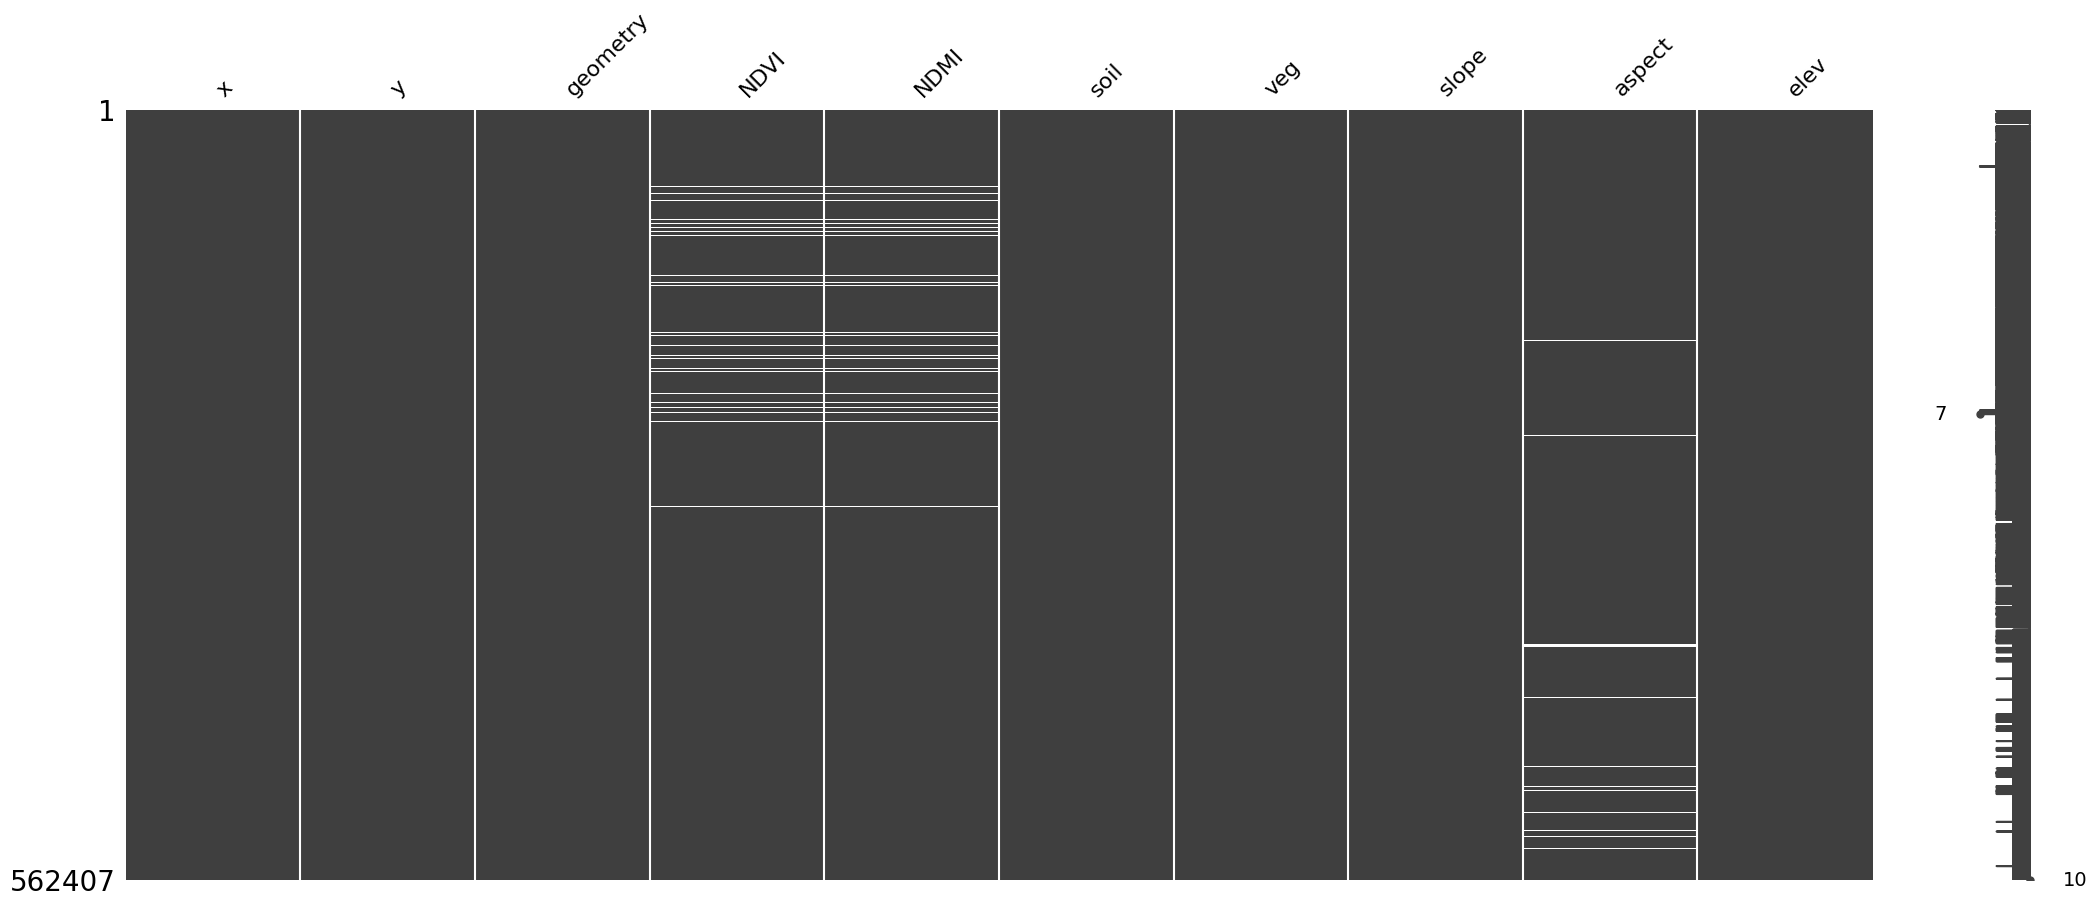

In [24]:
import missingno as msno
msno.matrix(sample_points_clean)

### **Filling NAs for the other columns**

In [25]:
df_aspect_zero = sample_points_clean[sample_points_clean.aspect.isna()]

In [26]:
df_aspect_zero.slope.unique()

array([ 0., nan], dtype=float32)

NDVI
* NA values are snowy peaks. Fill with value beween 0.0 and 0.1. See [Resource](https://www.usgs.gov/special-topics/remote-sensing-phenology/science/ndvi-foundation-remote-sensing-phenology#overview)

NDMI
* NA Values at the same points as in the NDVI. Fill in with -1.

Aspect
* NaN values that are left after dropping the vegetation NaNs seem to be plateaus (top of hills, bottom of valleys, ...). Here, a value for aspect does not make sense.
* fill with -1 as new value

In [27]:
sample_points_clean.NDMI.fillna(-1, inplace=True)
sample_points_clean.NDVI.fillna(0, inplace=True)
sample_points_clean.aspect.fillna(-1, inplace=True)
sample_points_clean.dropna(inplace = True)

In [ ]:
foxes_all_clean.NDMI.fillna(-1, inplace=True)
foxes_all_clean.NDVI.fillna(0, inplace=True)
foxes_all_clean.aspect.fillna(-1, inplace=True)
foxes_all_clean.dropna(inplace = True)

In [ ]:
foxes_resamp_clean.NDMI.fillna(-1, inplace=True)
foxes_resamp_clean.NDVI.fillna(0, inplace=True)
foxes_resamp_clean.aspect.fillna(-1, inplace=True)
foxes_resamp_clean.dropna(inplace = True)

### Save dataframes as shp-files
We transform the time collumns to then save them as shp-files.

In [29]:
foxes_all_final = foxes_all_clean.copy()
foxes_all_final["timestamp"] = foxes_all_final["t_"].apply(lambda x: dt.datetime.timestamp(x))
foxes_all_final["t_"] = foxes_all_final["t_"].dt.strftime("%Y-%m-%d-%H:%M:%S")
foxes_all_final.to_file("../data/cleaned_shapefiles/foxes_all.shp")

In [30]:
foxes_resamp_final = foxes_resamp_clean.copy()
foxes_resamp_final["timestamp"] = foxes_resamp_final["t_"].apply(lambda x: dt.datetime.timestamp(x))
foxes_resamp_final["t_"] = foxes_resamp_final["t_"].dt.strftime("%Y-%m-%d-%H:%M:%S")
foxes_resamp_final.to_file("../data/cleaned_shapefiles/foxes_resamp.shp")

In [ ]:
sample_points_clean.to_file("../data/cleaned_shapefiles/sample_points.shp")